In [14]:
import sys
sys.path.append('../')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [65]:
# I was doing it according to Data Analytics - Linear models - part 2 lecture and copying most of a code from 
# Kung_people.ipynb example. Begining is from from Airlines example.
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


In [21]:
#Mean of passenger deaths
Airline_data['Passenger deaths'].mean()

691.9

In [63]:
## Part 1

In [22]:
#Next I will try to do prior predictive checks with poisson distribution

In [47]:
with open('prior_deaths.stan', 'r') as file:
    print(file.read())


generated quantities {
    real lambda = normal_rng(692,250); //Mean is the mean of data, sigma higher for better representation
    int deaths = poisson_rng(lambda);
}


In [48]:
model_ppc=stan_utility.compile_model('prior_deaths.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecef5bad59d11deb8ff2fd72811fb127 NOW.


In [49]:
R = 1000
sim=model_ppc.sampling(data=dict(), 
                       iter=R, warmup=0, 
                       chains=1, 
                       refresh=R,
                       algorithm='Fixed_param',
                       seed=29042020)

In [50]:
params_sim=sim.extract()
lambda_sim=params_sim['lambda']
deaths_sim=params_sim['deaths']

/home/rsi96/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/rsi96/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


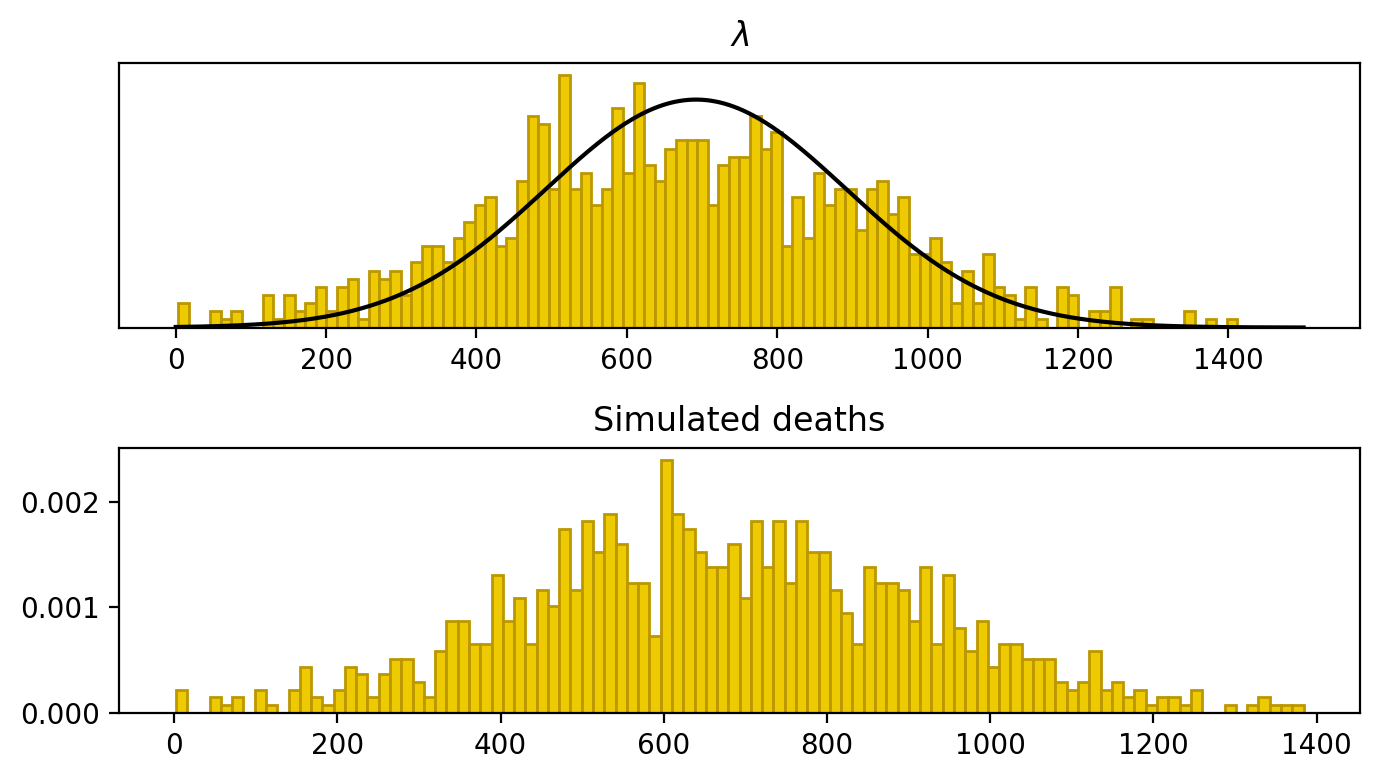

In [51]:
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[1])
ax1.hist(deaths_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('Simulated deaths')

ax2 = fig.add_subplot(gs[0])
ax2.set_yticks([])
ax2.hist(lambda_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)

ax2.plot(x,y,'black')
ax2.set_title('$\lambda$')
ax2.set_yticks([])

fig.tight_layout()
plt.show()



In [52]:
#Prior predictive is quite belivable so i think its ok

In [53]:
#Next is posterior and interference

In [54]:
with open('posterior_deaths.stan', 'r') as file:
    print(file.read())

data {
    int N;
    int deaths[N];
}

parameters{
    real<lower=0> lambda;
}

model {
    lambda ~ normal(692,250);
    deaths ~ poisson(lambda);
}

generated quantities {
    int deaths_gen = poisson_rng(lambda);
}


In [55]:
model_1_fit=stan_utility.compile_model('posterior_deaths.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_165cdf3f314dbefe0df173a6710ce28c NOW.


In [56]:
fit=model_1_fit.sampling(data=dict(N=len(Airline_data['Passenger deaths']),
                                   deaths=Airline_data['Passenger deaths']),
                         seed=28052020)

In [57]:
az.summary(fit,var_names=['lambda'],round_to=2,kind='stats')

,mean,sd,hpd_3%,hpd_97%
lambda,691.85,8.25,676.61,707.47


In [58]:
params_fit=fit.extract()
lambda_fit=params_fit['lambda']
deaths_pred=params_fit['deaths_gen']

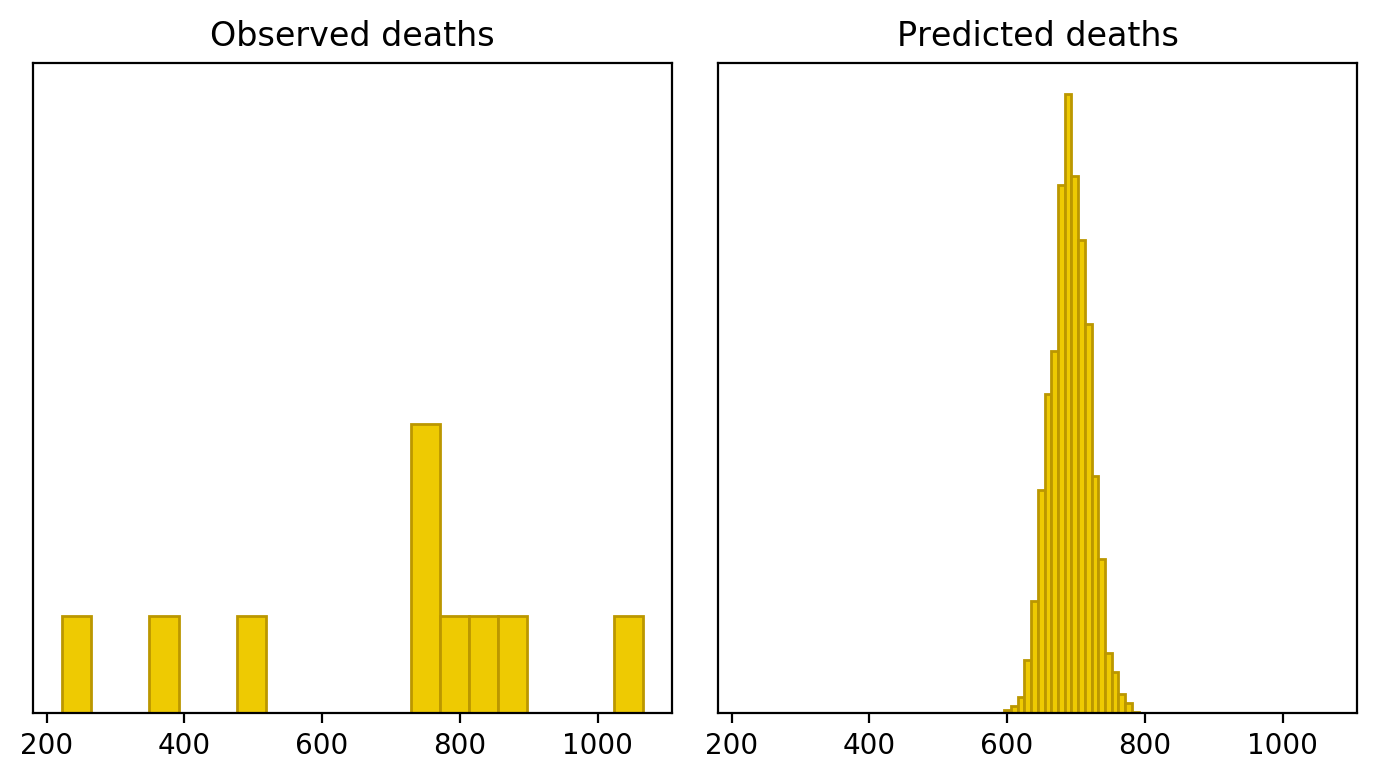

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(Airline_data['Passenger deaths'],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('Observed deaths')
ax.set_yticks(());
ax2=axes[1]
ax2.hist(deaths_pred,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Predicted deaths')
ax2.set_yticks(());
fig.tight_layout()

plt.show()

In [61]:
# We can see that predicted deaths are tightly packed around mean when observed deaths were spread wider. I think that is possible becouse we had few data and with larger amount of it we could get closer to mean.

In [62]:
## Part 2
#The intensity is constant, but rate is a product of intensity and miles flown.

In [66]:
#I think that intensity is mean of deaths

In [77]:
intensity=np.mean(Airline_data['Death rate'])
print('mean of intensity','{:4.3f}'.format(intensity))


mean of intensity 0.126


In [ ]:
#I was experimenting with beta distribution parameters and in the end this set seams ok

In [122]:
with open('model2.stan', 'r') as file:
    print(file.read())

data {
    int N;
    real miles[N];
}

generated quantities {
    real beta = beta_rng(2,10); 
    // beta distribution becouse death rate in our data is less than 1 nad more than 0, 
    int deaths[N];
    for(i in 1:N) {
        deaths[i] = poisson_rng(miles[i]*beta);
    }
}


In [123]:
model_ppc=stan_utility.compile_model('model2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b13b6bb70aefd94d5ae3127d9973585 NOW.


In [124]:
R = 1000
data_sim=dict(N=50,miles=np.linspace(Airline_data['Miles flown [100 mln miles]'].min(),Airline_data['Miles flown [100 mln miles]'].max()))
sim=model_ppc.sampling(data=data_sim, iter=R, warmup=0, chains=1, refresh=R,algorithm='Fixed_param',
                     seed=29042020)

In [125]:
params_sim=sim.extract()
beta_sim=params_sim['beta']

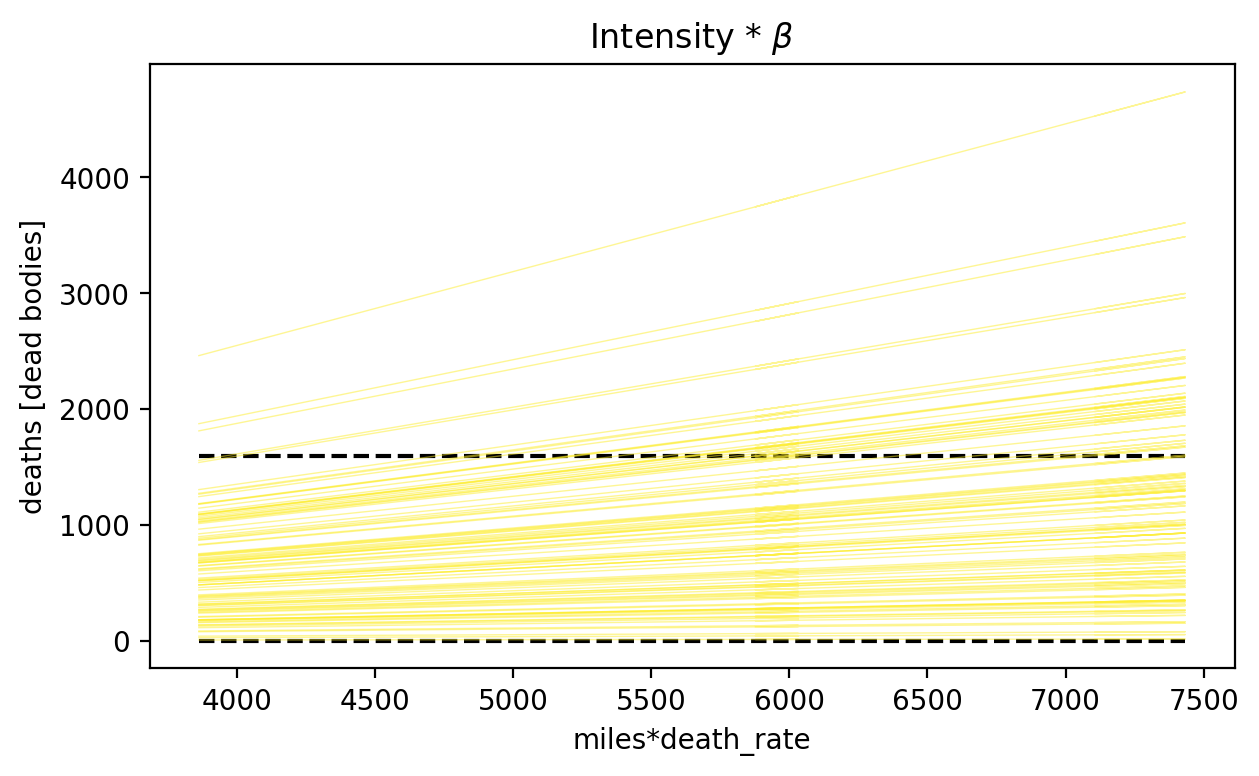

In [126]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
#Here I'm using 0 and 1066*1.5 values for lines becouse I think that are quite beliveable numbers
axes.hlines([0,1066*1.5],xmin=Airline_data['Miles flown [100 mln miles]'].min(),xmax=Airline_data['Miles flown [100 mln miles]'].max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(Airline_data['Miles flown [100 mln miles]'],beta_sim[i]*Airline_data['Miles flown [100 mln miles]'],color=mid,alpha=0.5,linewidth=0.5)
axes.set_xlabel('miles*death_rate')
axes.set_ylabel('deaths [dead bodies]')
axes.set_title(r'Intensity * $\beta$')
plt.show()

In [127]:
from DA_tools import ribbon_plot, light, light_highlight, mid, mid_highlight, dark, dark_highlight

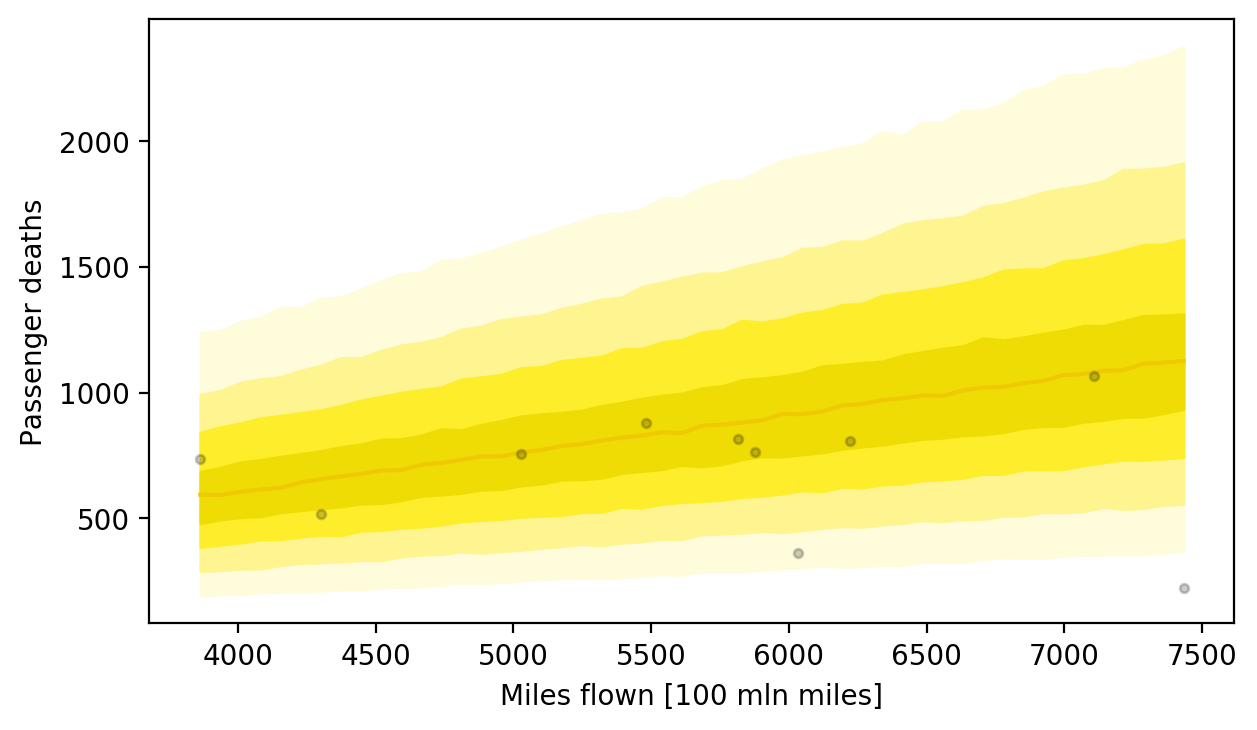

In [128]:
deaths_sim=params_sim['deaths']

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(data_sim['miles'],deaths_sim,axes)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],Airline_data['Passenger deaths'],color='black',alpha=0.2,s=10)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('Passenger deaths')
plt.show()

In [132]:
with open('model2_posterior.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] miles;
  int deaths[N];
}

parameters {
  real beta;
}

transformed parameters {
  vector[N] lambda = miles*beta;
}

model {
  beta ~ beta(2,10);
  deaths ~ poisson(lambda);
}

generated quantities {
  real deaths_gen[N];
  for (i in 1:N) {
    deaths_gen[i] = poisson_rng(lambda[i]);
  }
}


In [133]:
model_2_fit=stan_utility.compile_model('model2_posterior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1e3d751b131ab938fc687c0ff3a70658 NOW.


In [135]:
data_fit=dict(N=len(Airline_data['Passenger deaths']),
              deaths=Airline_data['Passenger deaths'],
              miles=Airline_data['Miles flown [100 mln miles]'])

fit=model_2_fit.sampling(data=data_fit,seed=28052020)

params_fit=fit.extract()
lambda_fit=params_fit['lambda']
beta_fit=params_fit['beta']
deaths_pred=params_fit['deaths_gen']

az.summary(fit,var_names=['lambda','beta'],round_to=2,kind='stats')

,mean,sd,hpd_3%,hpd_97%
lambda[0],467.75,5.51,457.40,477.72
lambda[1],520.66,6.13,509.15,531.76
lambda[2],608.69,7.16,595.23,621.66
lambda[3],663.67,7.81,648.99,677.81
lambda[4],703.99,8.29,688.41,718.99
lambda[5],730.50,8.60,714.35,746.07
lambda[6],711.61,8.38,695.87,726.78
lambda[7],753.51,8.87,736.84,769.57
lambda[8],900.02,10.59,880.11,919.20
lambda[9],860.55,10.13,841.51,878.89


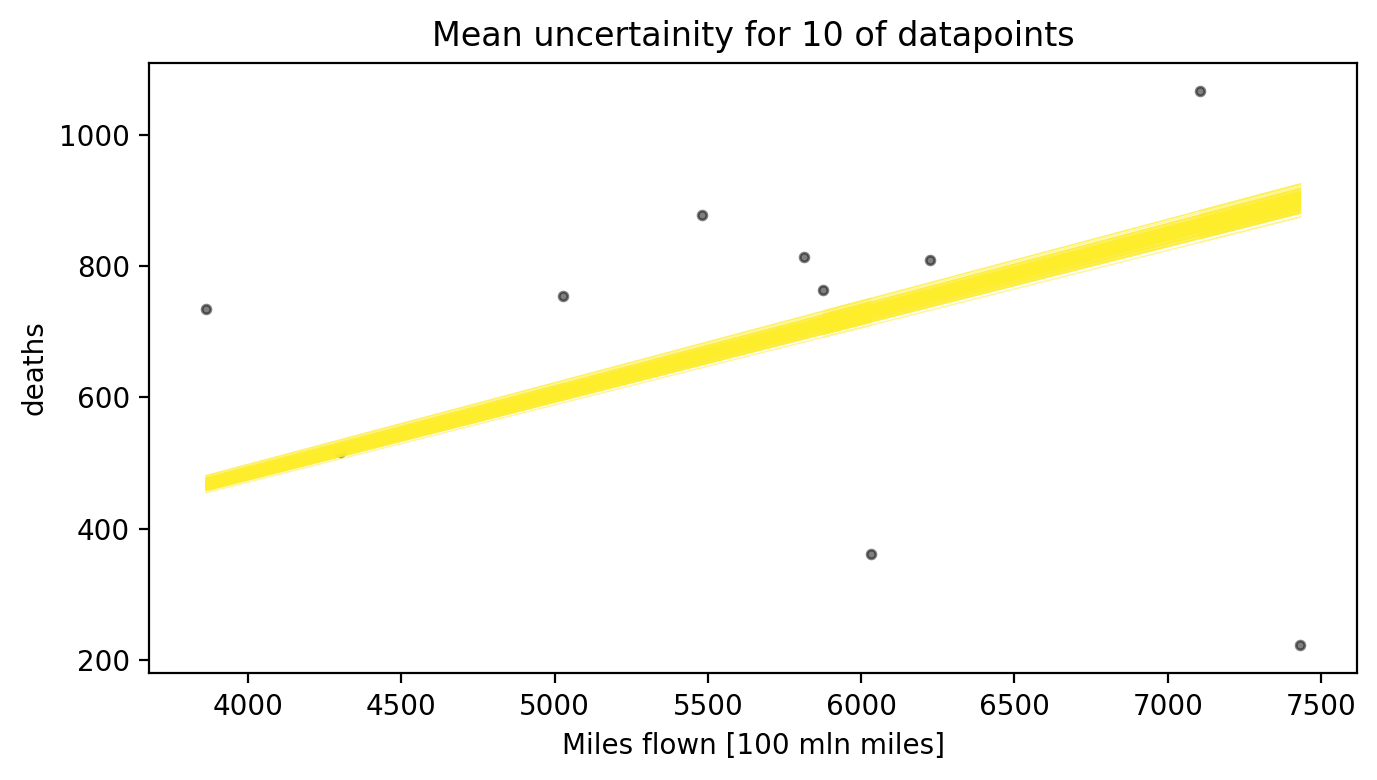

In [150]:
fig, axes = plt.subplots(1,1, figsize=(7, 4),sharey=True,sharex=True)
for i in range(100):
    axes.plot(Airline_data['Miles flown [100 mln miles]'],
              beta_fit[i]*Airline_data['Miles flown [100 mln miles]'],
              color=mid,
              alpha=0.5,linewidth=0.5)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],Airline_data['Passenger deaths'],color='black',alpha=0.5,s=10)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('deaths')
axes.set_title('Mean uncertainity for {} of datapoints'.format(len(Airline_data['Passenger deaths'])))
fig.tight_layout()
plt.show()

Sorting


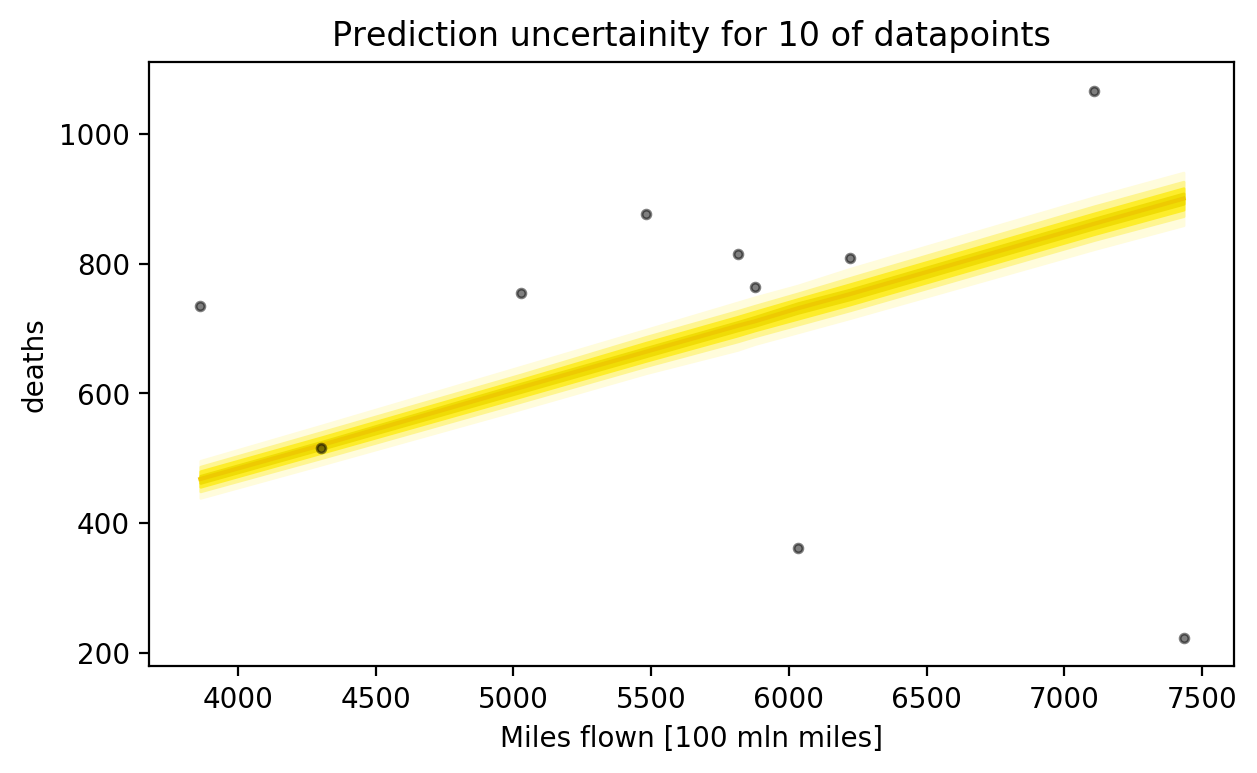

In [151]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(Airline_data['Miles flown [100 mln miles]'].values,deaths_pred,axes)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],Airline_data['Passenger deaths'],color='black',alpha=0.5,s=10)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('deaths')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(Airline_data['Passenger deaths'])))
plt.show()

In [ ]:
# Model is not very good. In my opinion we would need much more data to obtain proper prediction. But thanks to this model we could observe that with more miles flown more people should die whih is logical.
#Also for example year 1984 is weird and we could wonder why was that. We could analyze this data according to for example safety polices or airplane models to obtain more detailed information